In [1]:
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import utils
import seaborn as sns
import importlib
from tqdm import tqdm
from joblib import Parallel, delayed
import multiprocessing as mp
import warping
import matplotlib.cm as cm

path_figs = "./Figs/"

path = "./SL3/SL3"

path_misc = "./SL3_miscs/"

fingers = [0, 1, 2, 3, 4]

iti = 500

total_sub_num = 16

n_samples = 300
n_samples_left_right = 30


In [2]:
importlib.reload(utils)

<module 'utils' from '/Users/amin/projects/SequenceLearningAtsushi/utils.py'>

In [3]:
subjs = pd.read_csv(path_misc + "subjs.csv")

In [4]:
# subjs = utils.remove_error_trials(subjs)

In [5]:
rank_df = pd.DataFrame(index = subjs.index, dtype='int')
for subnum, data in subjs.groupby('SubNum'):
    data = data.sort_values(by = ['BN', 'TN'])
    data['N'] = data.groupby(['BN', 'TN']).ngroup() + 1
    rank_df.loc[data.index, 'N'] = data['N'].astype('int')
        

subjs['N'] = rank_df['N'].astype('int')

In [6]:
subjs['ET'] = subjs['MT'] + subjs['IPI0']

In [7]:
subjs['ET'].median() // 5

312.0

## Mov Files:

In [8]:
aligned_cut_force = pd.read_csv(utils.path_misc+'aligned_cut_force.csv', sep = '\t')

In [9]:

forces = [1,2,3,4,5]

num_sequences = 4
num_cores = mp.cpu_count()

all_error_trials = {}


num_trials = 1200

all_error_trials = {}

all_trials_MT = {}

seq_types = subjs['seqType'].unique()

for seqnum, seq_data in subjs.groupby('seqType'):
    for hand, hand_data in seq_data.groupby('board'):


        for subind, (subnum, subdata) in enumerate(hand_data.groupby('SubNum')):
            
            error_ranks = subdata[subdata['seqError'] > 0]['N'].unique().astype('int')
            all_error_trials[seqnum, hand, subnum] = error_ranks 




for seqnum, seq_data in subjs.groupby('seqType'):
    for hand, hand_data in seq_data.groupby('board'):
        for subind, (subnum, subdata) in enumerate(hand_data.groupby('SubNum')):
            MT = subdata['MT'].to_numpy()
            all_trials_MT[seqnum, hand, subnum] = MT


13
14
12
16
13
14
12
14


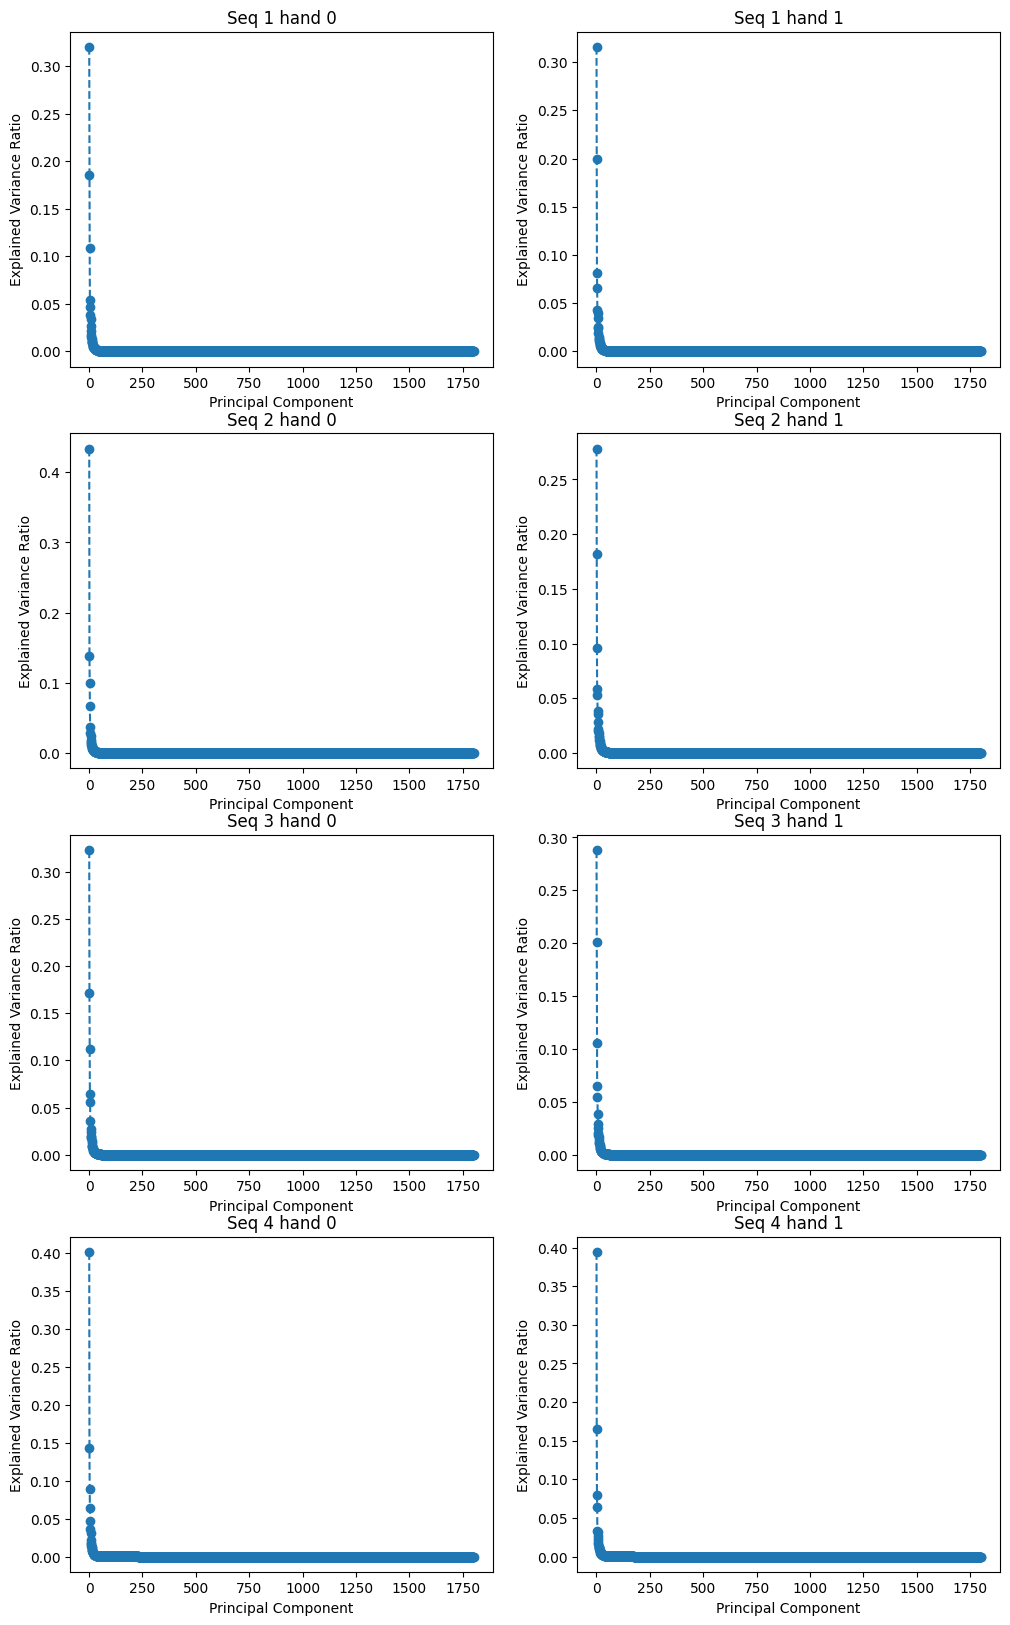

In [98]:
from sklearn.decomposition import PCA
forces = [1,2,3,4,5]
import pickle

fig, axs = plt.subplots(4, 2, figsize = (12, 20))

num_sequences = 4
num_cores = mp.cpu_count()

reduced_forces_correct_dict = {}
reduced_forces_all_dict = {}
components = {}

n_dim_reduction = 15


# num_trials = 1200


seq_types = subjs['seqType'].unique()

for seqnum, seq_data in aligned_cut_force.groupby('seqType'):
    for hand, hand_data in seq_data.groupby('board'):
        pivot_datas = []
        for subind, (subnum, subdata) in enumerate(hand_data.groupby('SubNum')):
            subdata_correct = utils.remove_error_trials(subdata)
            pivot_datas.append(subdata_correct.pivot_table(index = ['N'], columns = ['Force_Number', 'time'], values = 'Force_Value').dropna().to_numpy())
            # pca = PCA()
            # pca.fit(pivot_data)
            # components[seqnum, hand, subnum] = pca.components_[:n_dim_reduction]

            # explained_variance = pca.explained_variance_ratio_
            # dim_reduced = np.argmax(np.cumsum(explained_variance) >= 0.9)
            # # print(dim_reduced)

            # reduced_forces_correct_dict[seqnum, hand, subnum] = pca.transform(pivot_data)[:,:n_dim_reduction]
            # pivot_data = subdata.pivot_table(index = ['N'], columns = ['Force_Number', 'time'], values = 'Force_Value').dropna().to_numpy()
            # reduced_forces_all_dict[seqnum, hand, subnum] = pca.transform(pivot_data)[:,:n_dim_reduction]
        pivot_datas = np.concatenate(pivot_datas, axis = 0)
        pca = PCA()
        pca.fit(pivot_datas)
        explained_variance = pca.explained_variance_ratio_
        dim_reduced = np.argmax(np.cumsum(explained_variance) >= 0.9)
        print(dim_reduced)
        for subind, (subnum, subdata) in enumerate(hand_data.groupby('SubNum')):
            subdata_correct = utils.remove_error_trials(subdata)
            pivot_data = subdata_correct.pivot_table(index = ['N'], columns = ['Force_Number', 'time'], values = 'Force_Value').dropna().to_numpy()
            components[seqnum, hand, subnum] = pca.components_[:n_dim_reduction]
            reduced_forces_correct_dict[seqnum, hand, subnum] = pca.transform(pivot_data)[:,:n_dim_reduction]
            pivot_data = subdata.pivot_table(index = ['N'], columns = ['Force_Number', 'time'], values = 'Force_Value').dropna().to_numpy()
            reduced_forces_all_dict[seqnum, hand, subnum] = pca.transform(pivot_data)[:,:n_dim_reduction]






        seq_ind = seqnum - 1
        ax_ind = (seq_ind, hand)
        axs[ax_ind].plot(np.arange(1, len(explained_variance) + 1), explained_variance, marker = 'o', linestyle = '--')
        # axs[ax_ind].set_yscale('log')
        axs[ax_ind].set_title(f'Seq {seqnum} hand {hand}')
        axs[ax_ind].set_xlabel('Principal Component')
        axs[ax_ind].set_ylabel('Explained Variance Ratio')
        # axs[ax_ind].set_ylim([1e-3, 1])

            

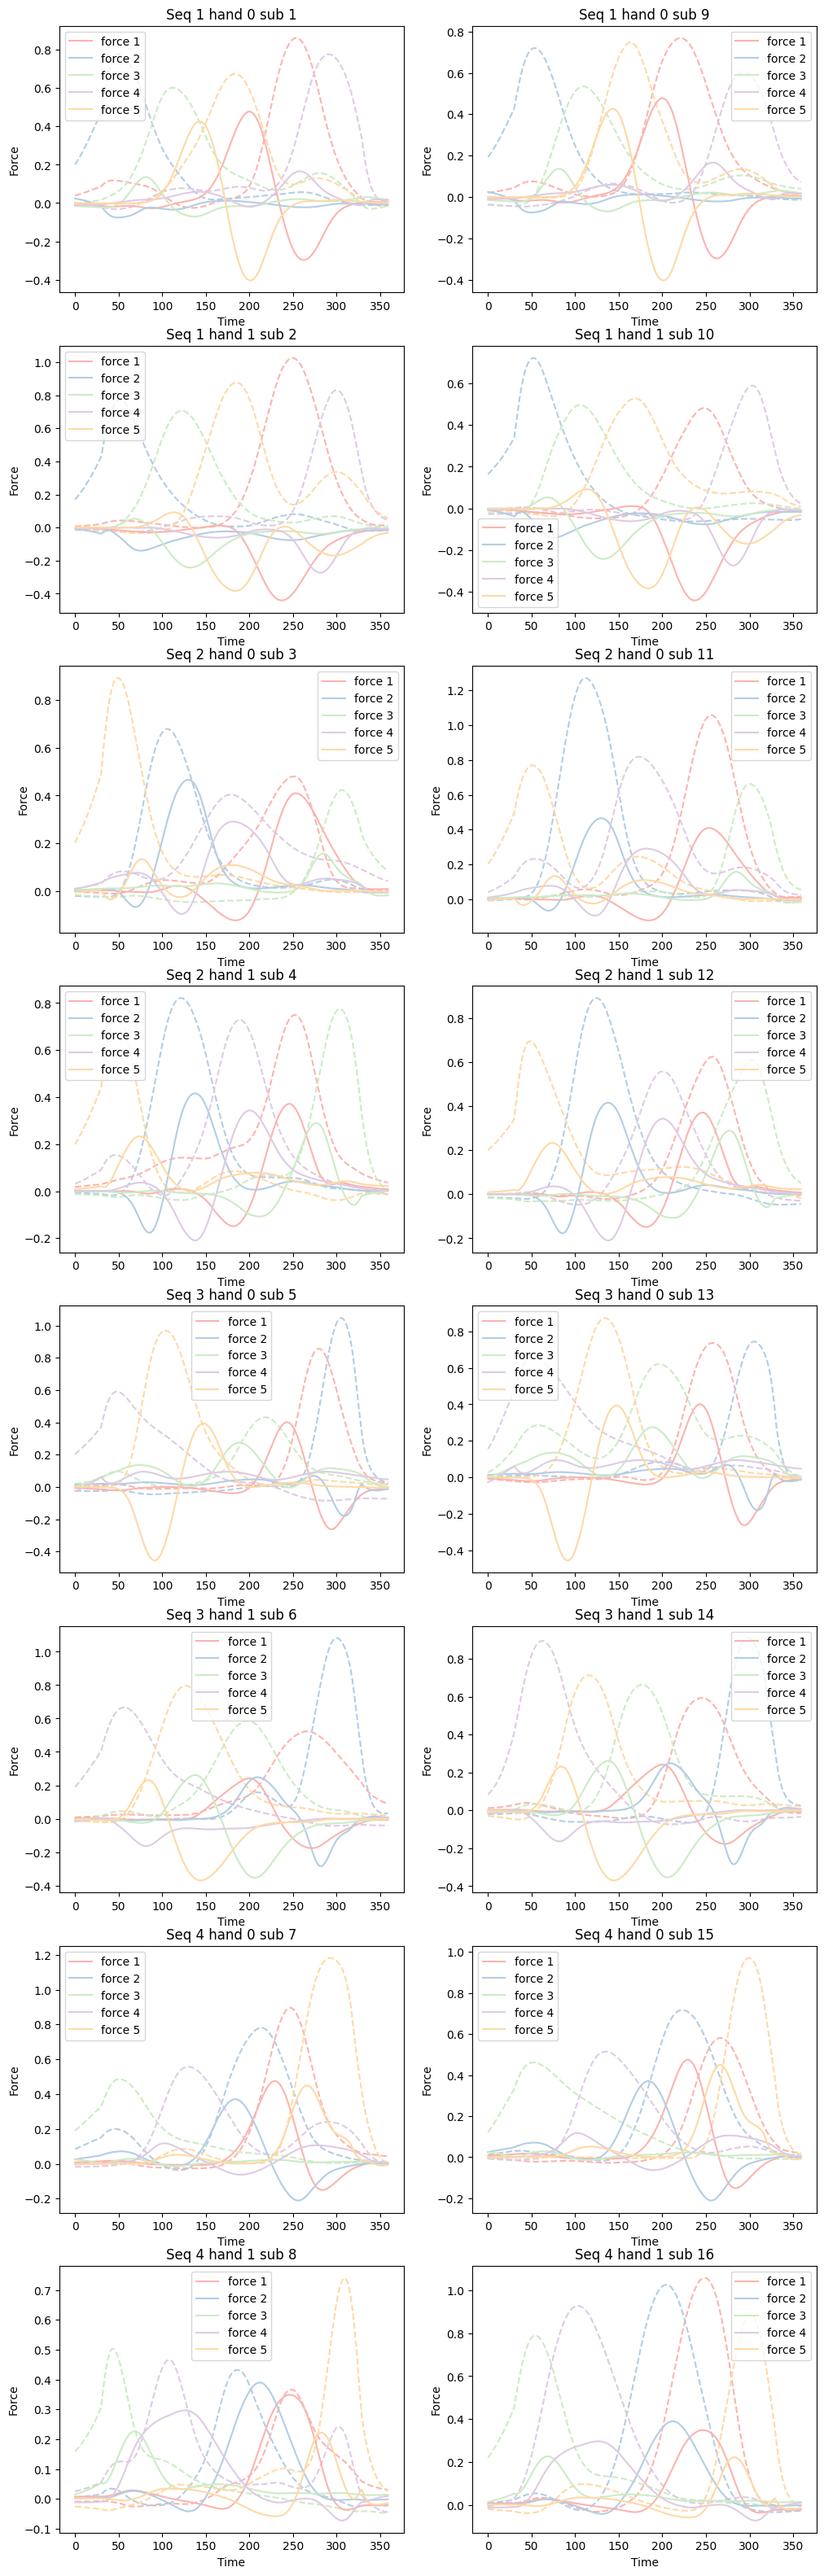

In [16]:
from sklearn.decomposition import PCA
forces = [1,2,3,4,5]
import pickle

fig, axs = plt.subplots(4*2, 2, figsize = (12, 40))

num_sequences = 4
num_cores = mp.cpu_count()

component_rank = 0

cmap = cm.Pastel1

# num_trials = 1200


seq_types = subjs['seqType'].unique()

for seqnum, seq_data in aligned_cut_force.groupby('seqType'):
    for hand, hand_data in seq_data.groupby('board'):
        for subind, (subnum, subdata) in enumerate(hand_data.groupby('SubNum')):
            subdata = utils.remove_error_trials(subdata)
            pivot_data = subdata.pivot_table(index = ['N'], columns = ['Force_Number', 'time'], values = 'Force_Value').dropna().to_numpy()
            forces = components[seqnum, hand, subnum][component_rank].reshape(len(fingers), n_samples_left_right * 2 + n_samples)

            seq_ind = seqnum - 1
            ax_ind = (seq_ind * 2 + hand, subind)


            # mean force profile
            mean_forces = np.mean(pivot_data, axis = 0).reshape(len(fingers), n_samples_left_right * 2 + n_samples)
            for force_ind, force in enumerate(mean_forces):
                axs[ax_ind].plot(force, linestyle = '--', color = cmap(force_ind))    
            # Plotting principal components
            for force_ind, force in enumerate(forces):
                axs[ax_ind].plot(force * 5, label = f'force {force_ind + 1}', color = cmap(force_ind))
            axs[ax_ind].set_title(f'Seq {seqnum} hand {hand} sub {subnum}')
            axs[ax_ind].set_xlabel('Time')
            axs[ax_ind].set_ylabel('Force')
            axs[ax_ind].legend()

            

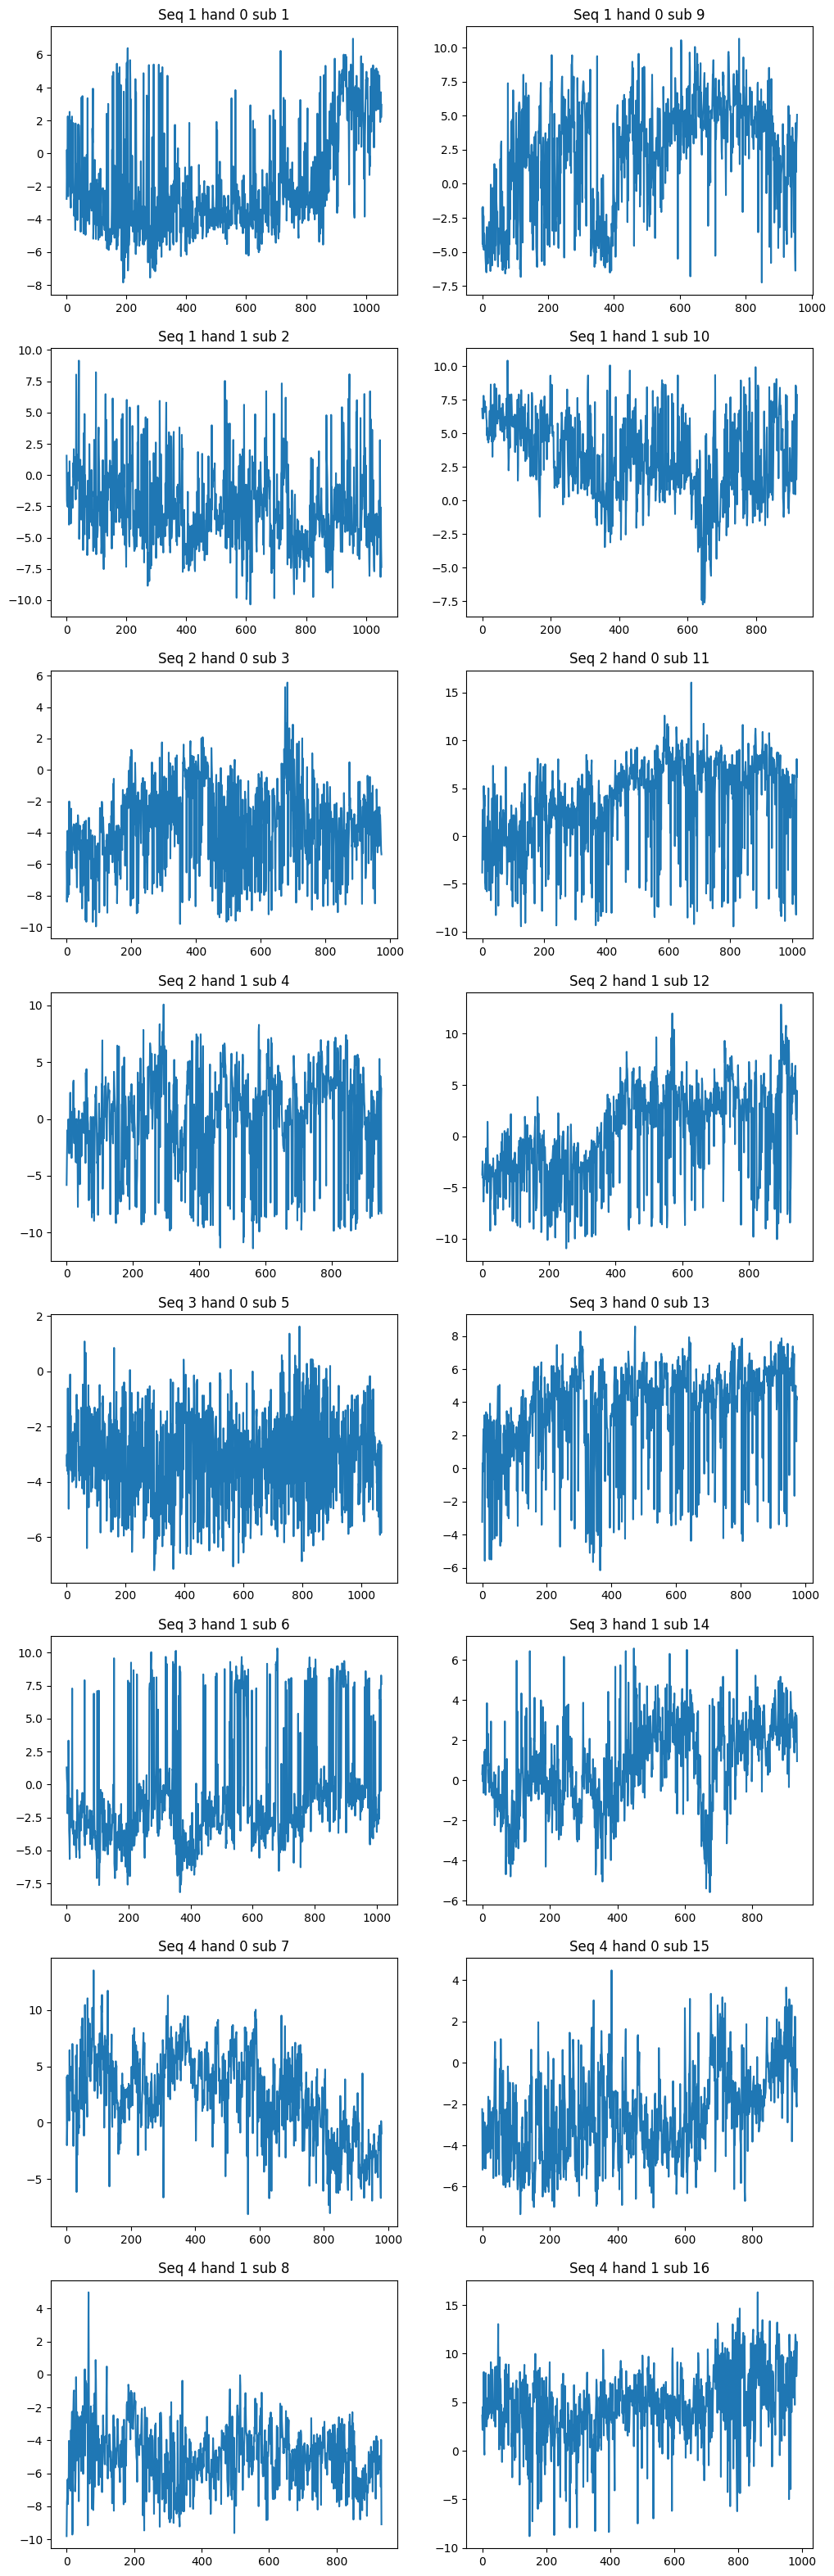

In [17]:
fig , axs = plt.subplots(4 * 2, 2, figsize = (12, 40))

component_rank = 0

for idx, ((seqnum, hand, subnum), forces) in enumerate(reduced_forces_correct_dict.items()):
    plot_ind = (idx//2, idx % 2)
    axs[plot_ind].plot(forces[:,component_rank])
    axs[plot_ind].set_title(f'Seq {seqnum} hand {hand} sub {subnum}')
    # plt.show()

In [238]:
#project and plot random walk on the first 3 principal components interactively in 3D
import plotly.graph_objects as go

for seqnum, seq_data in subjs.groupby('seqType'):
    for hand, hand_data in seq_data.groupby('board'):
        fig = go.Figure()
        for subind, (subnum, subdata) in enumerate(hand_data.groupby('SubNum')):
            forces = reduced_forces_correct_dict[seqnum, hand, subnum]
            window_size = 51
            kernel = np.ones(window_size) / window_size
            smoothed_states = np.zeros_like(forces)
            for i in range(n_dim_reduction):
                smoothed_states[:,i] = np.convolve(forces[:,i], kernel, mode = 'same')
            
            color = np.arange(len(forces))
    
            fig.add_trace(go.Scatter3d(x=smoothed_states[:,0], y=smoothed_states[:,1], z=smoothed_states[:,2], mode='lines', line=dict(color=color, colorscale='Viridis', width=1, showscale = True)))
    
    
        fig.update_layout(scene = dict(
                        xaxis_title='PC1',
                        yaxis_title='PC2',
                        zaxis_title='PC3'), 
                        width=800,
                        height=800, 
                        margin=dict(l=100, r=100, b = 100, t=100),
                        title_text = f'Seq {seqnum} hand {hand}')
                        
        fig.show()




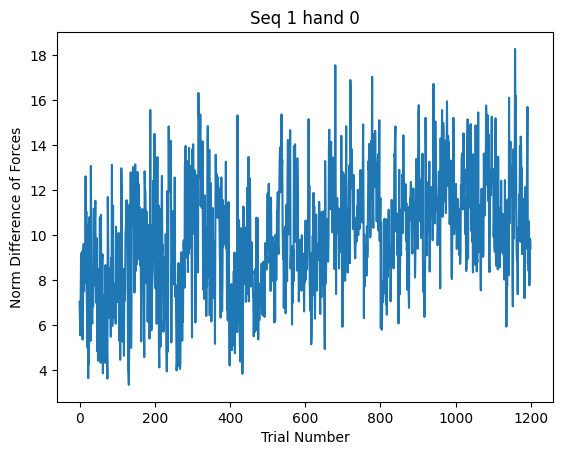

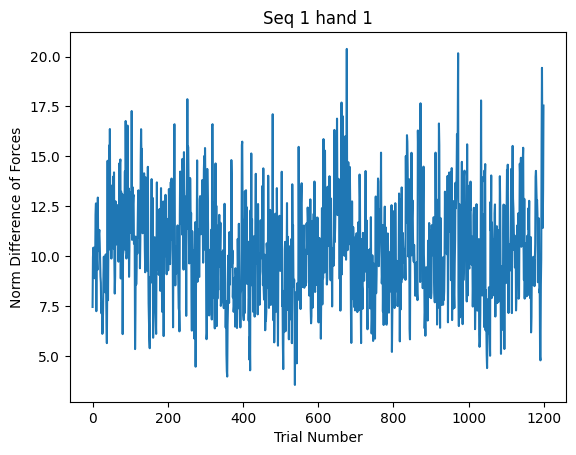

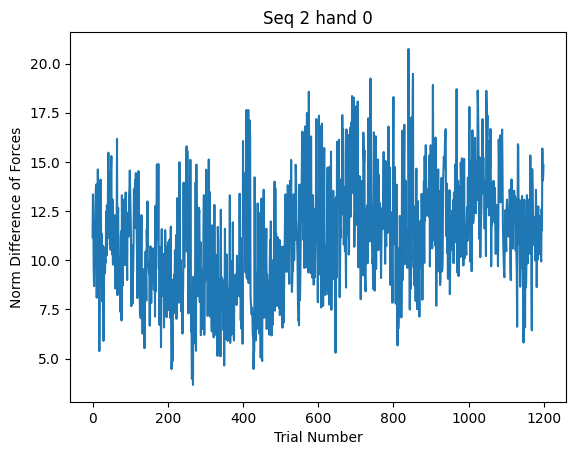

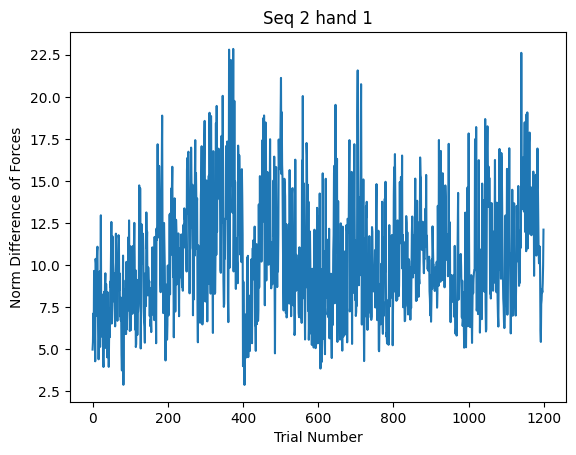

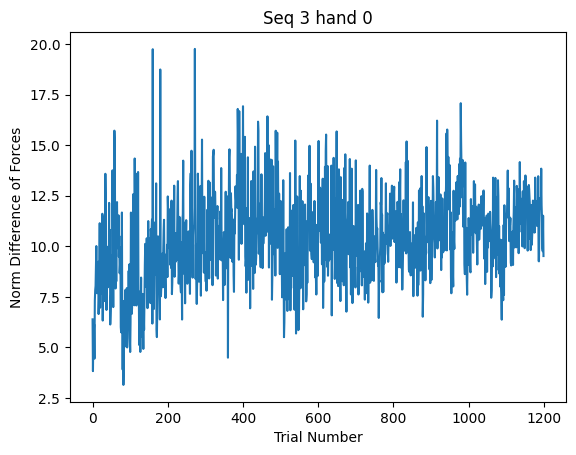

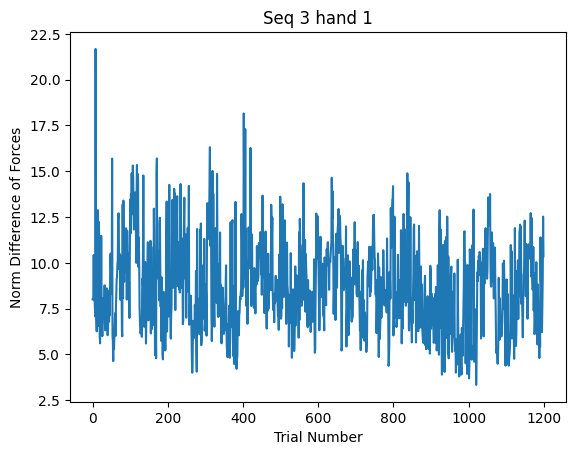

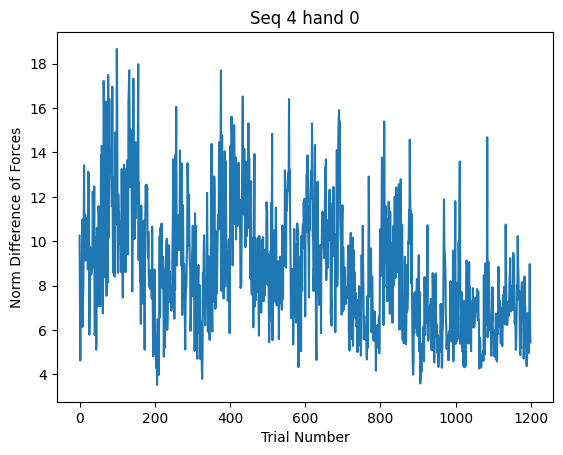

In [116]:
#project and plot random walk on the first 3 principal components interactively in 3D
import plotly.graph_objects as go

for seqnum, seq_data in subjs.groupby('seqType'):
    for hand, hand_data in seq_data.groupby('board'):
        if not (seqnum == 4 and hand == 1):
            forces = []
            for subind, (subnum, subdata) in enumerate(hand_data.groupby('SubNum')):
                error_trials = all_error_trials[seqnum, hand, subnum]
                sub_force = reduced_forces_all_dict[seqnum, hand, subnum].copy()
                sub_force[error_trials-1, :] = np.nan
                for dim in range(n_dim_reduction):
                    sub_force[:,dim] = np.interp(np.arange(0, num_trials), np.arange(0, num_trials)[~np.isnan(sub_force[:,dim])], sub_force[~np.isnan(sub_force[:,dim]),dim])
                forces.append(sub_force)

            forces = np.array(forces)
            diff_forces = np.diff(forces, axis = 0).squeeze()
            diff_norms = np.linalg.norm(diff_forces, axis = 1)
            plt.figure()
            plt.plot(diff_norms)
            plt.title(f'Seq {seqnum} hand {hand}')
            plt.ylabel('Norm Difference of Forces')
            plt.xlabel('Trial Number')




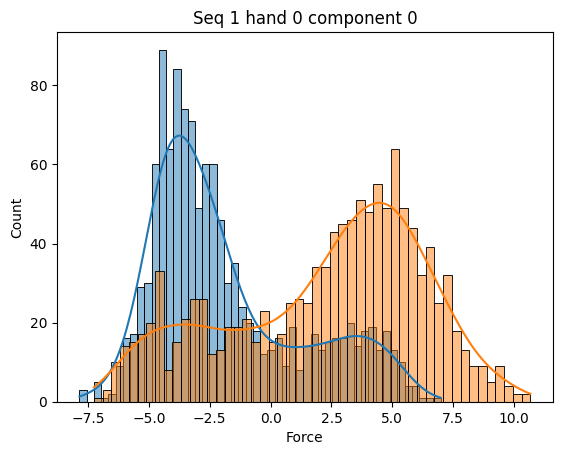

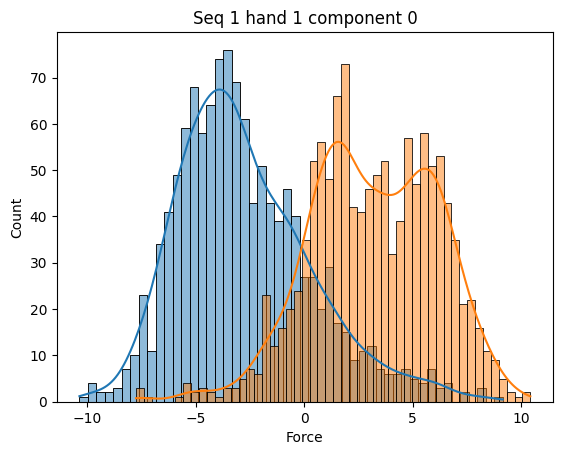

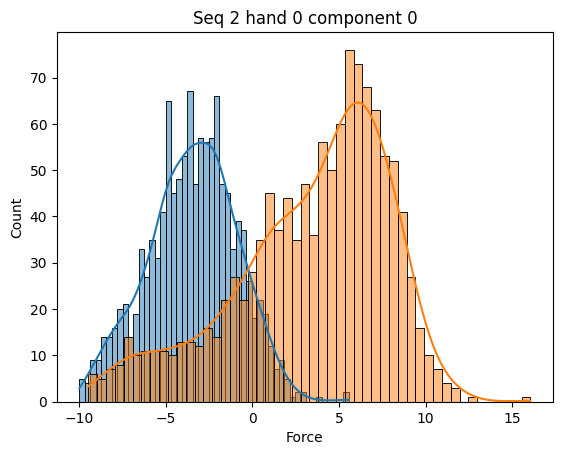

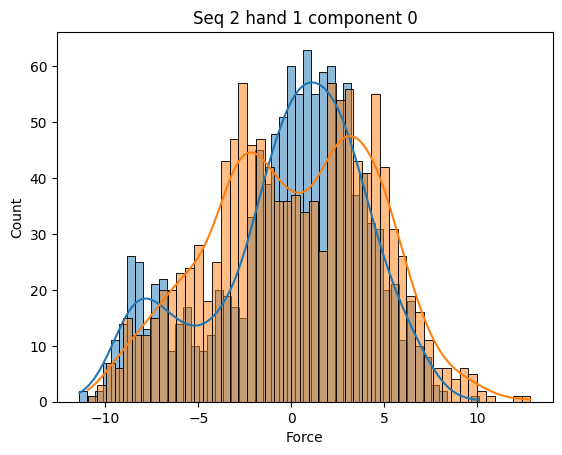

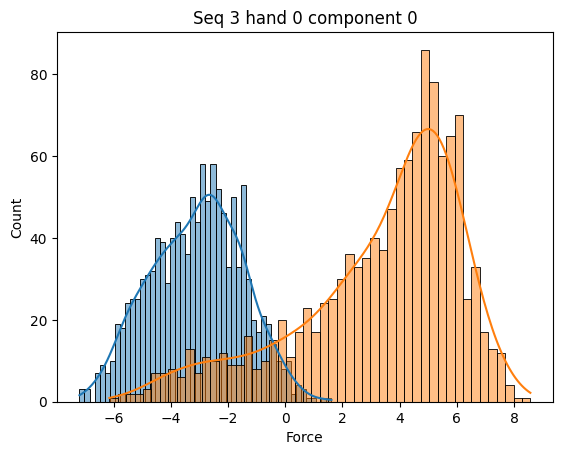

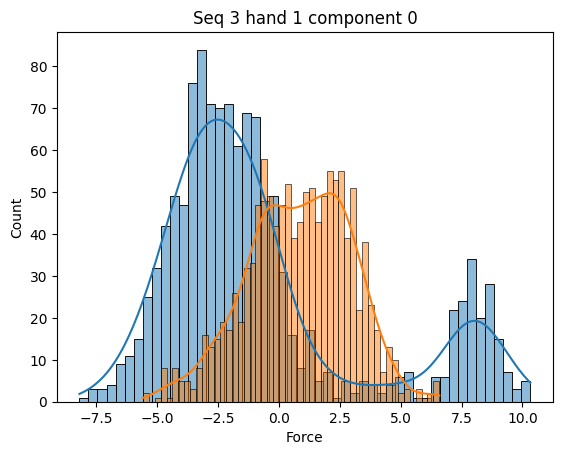

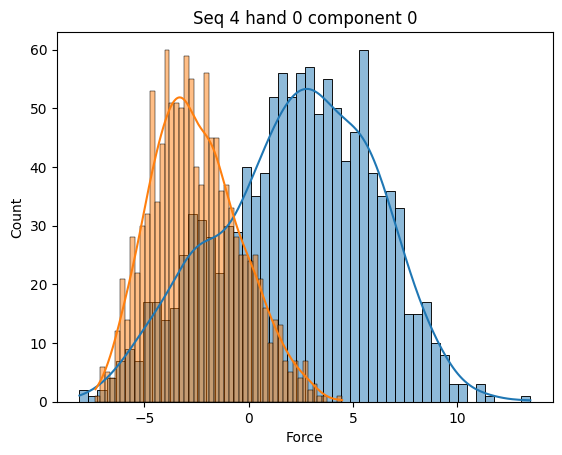

In [211]:
component = 0

for seqnum, seq_data in subjs.groupby('seqType'):
    for hand, hand_data in seq_data.groupby('board'):
        if not (seqnum == 4 and hand == 1):
            forces = []
            plt.figure()
            for subind, (subnum, subdata) in enumerate(hand_data.groupby('SubNum')):
                error_trials = all_error_trials[seqnum, hand, subnum]
                sub_force = reduced_forces_all_dict[seqnum, hand, subnum].copy()
                sub_force[error_trials-1, :] = np.nan
                for dim in range(n_dim_reduction):
                    sub_force[:,dim] = np.interp(np.arange(0, num_trials), np.arange(0, num_trials)[~np.isnan(sub_force[:,dim])], sub_force[~np.isnan(sub_force[:,dim]),dim]) 
                forces.append(sub_force)
                sns.histplot(sub_force[:,component], bins = 50, kde = True, label = f'Sub {subnum}')

            plt.title(f'Seq {seqnum} hand {hand} component {component}')
            plt.xlabel('Force')
            # forces = np.array(forces)
            # diff_forces = np.diff(forces, axis = 0).squeeze()

            # diff_norms = np.linalg.norm(diff_forces, axis = 1)
            # plt.plot(diff_norms)
            # plt.title(f'Seq {seqnum} hand {hand}')
            # plt.ylabel('Norm Difference of Forces')
            # plt.xlabel('Trial Number')




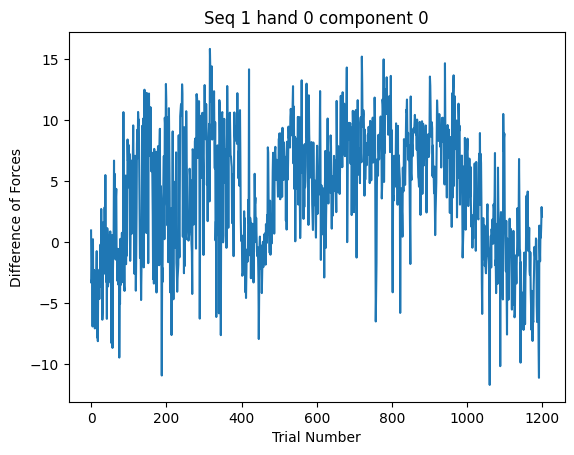

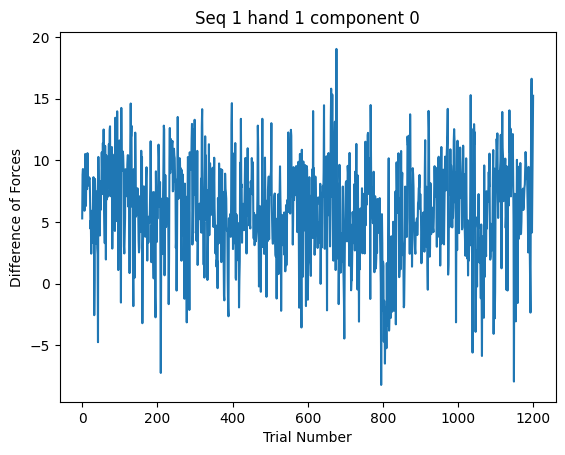

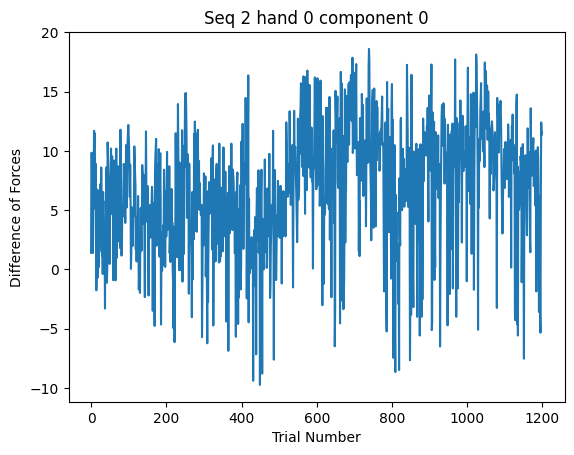

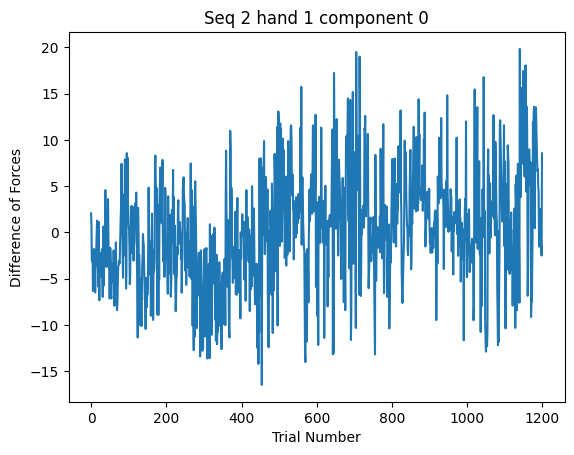

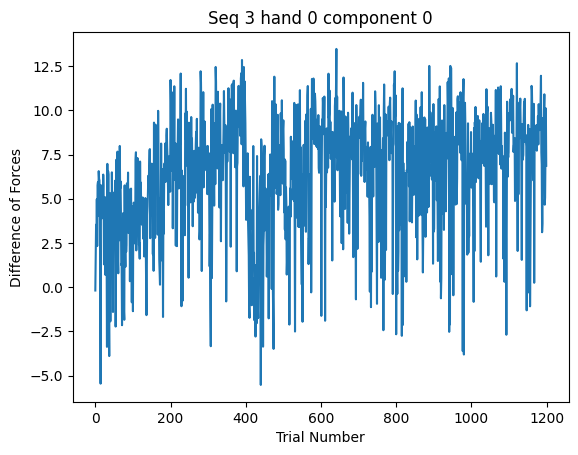

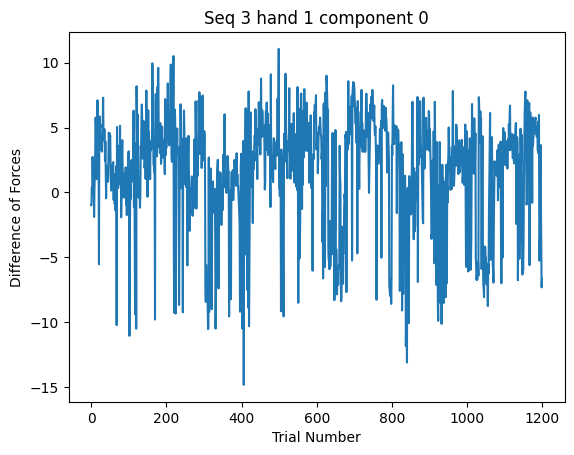

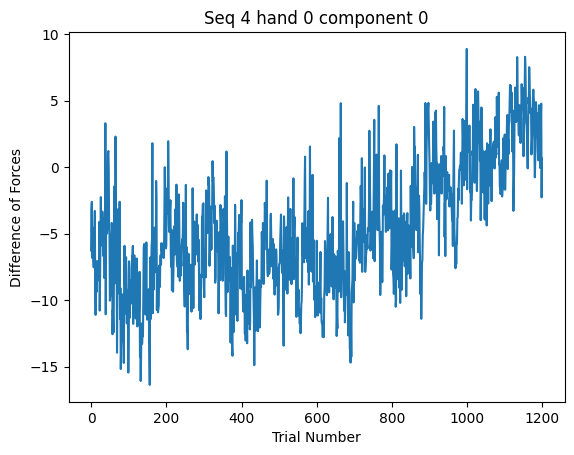

In [212]:
component = 0

for seqnum, seq_data in subjs.groupby('seqType'):
    for hand, hand_data in seq_data.groupby('board'):
        if not (seqnum == 4 and hand == 1):
            forces = []
            plt.figure()
            for subind, (subnum, subdata) in enumerate(hand_data.groupby('SubNum')):
                error_trials = all_error_trials[seqnum, hand, subnum]
                sub_force = reduced_forces_all_dict[seqnum, hand, subnum].copy()
                sub_force[error_trials-1, :] = np.nan
                for dim in range(n_dim_reduction):
                    sub_force[:,dim] = np.interp(np.arange(0, num_trials), np.arange(0, num_trials)[~np.isnan(sub_force[:,dim])], sub_force[~np.isnan(sub_force[:,dim]),dim]) 
                forces.append(sub_force[:,component])

            plt.title(f'Seq {seqnum} hand {hand} component {component}')

            forces = np.array(forces)
            diff_forces = np.diff(forces, axis = 0).squeeze()
            plt.plot(diff_forces)
            plt.ylabel('Difference of Forces')
            plt.xlabel('Trial Number')
            # diff_norms = np.linalg.norm(diff_forces, axis = 1)
            # plt.plot(diff_norms)
            # plt.title(f'Seq {seqnum} hand {hand}')
            # plt.ylabel('Norm Difference of Forces')
            # plt.xlabel('Trial Number')




In [213]:
# #project and plot random walk on the first 3 principal components interactively in 3D
# import plotly.graph_objects as go

# for seqnum, seq_data in subjs.groupby('seqType'):
#     for hand, hand_data in seq_data.groupby('board'):
#         if not (seqnum == 4 and hand == 1):
#             forces = []
#             for subind, (subnum, subdata) in enumerate(hand_data.groupby('SubNum')):
#                 error_trials = all_error_trials[seqnum, hand, subnum]
#                 sub_force = reduced_forces_all_dict[seqnum, hand, subnum].copy()
#                 sub_force[error_trials-1, :] = np.nan
#                 for dim in range(n_dim_reduction):
#                     sub_force[:,dim] = np.interp(np.arange(0, num_trials), np.arange(0, num_trials)[~np.isnan(sub_force[:,dim])], sub_force[~np.isnan(sub_force[:,dim]),dim])
#                 forces.append(sub_force)

#             forces = np.array(forces)
#             corrs = np.corrcoef(forces[0], forces[1])
#             plt.figure()
#             plt.plot([corrs[i, i + num_trials] for i in range(num_trials)])
#             plt.title(f'Seq {seqnum} hand {hand}')
#             plt.ylabel('Corr of Forces')
#             plt.xlabel('Trial Number')




In [222]:
moving_window_forces.shape

(2, 1200, 15)

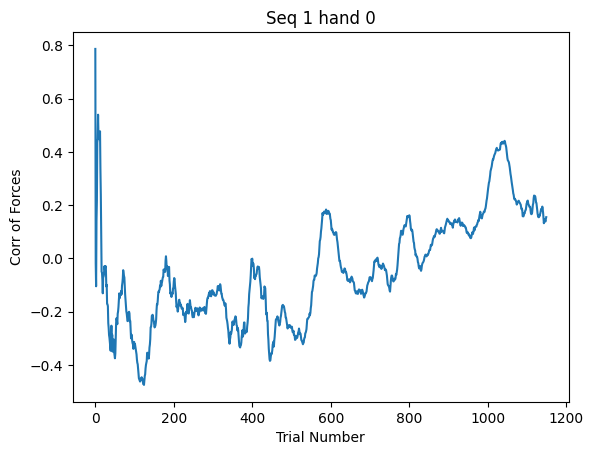

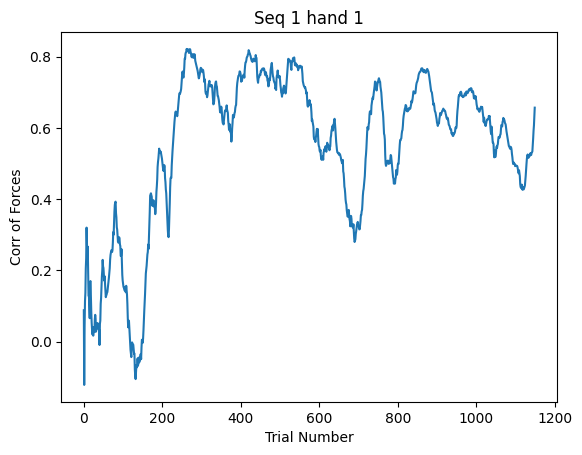

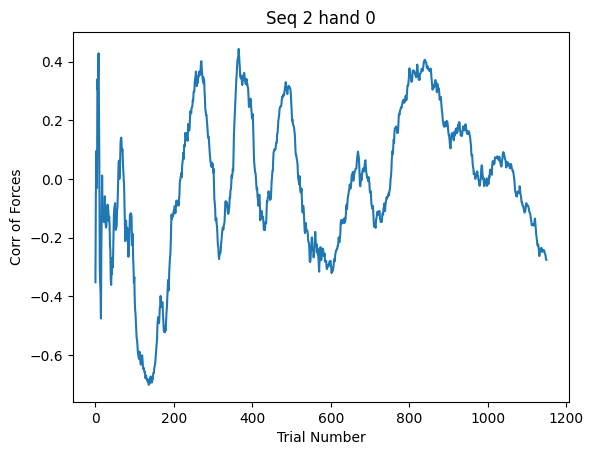

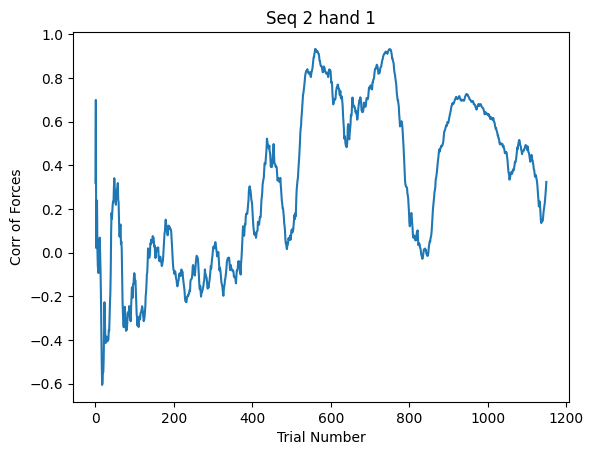

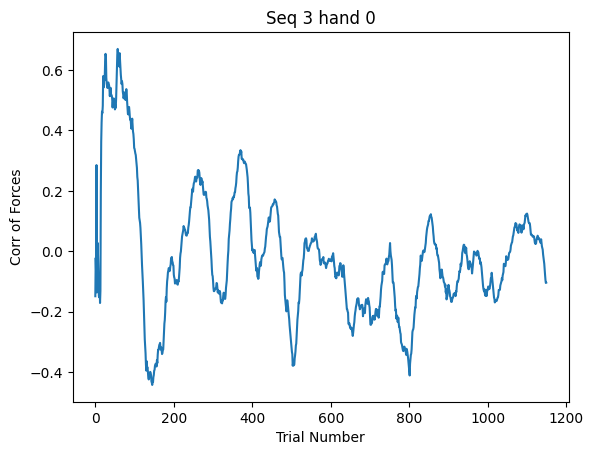

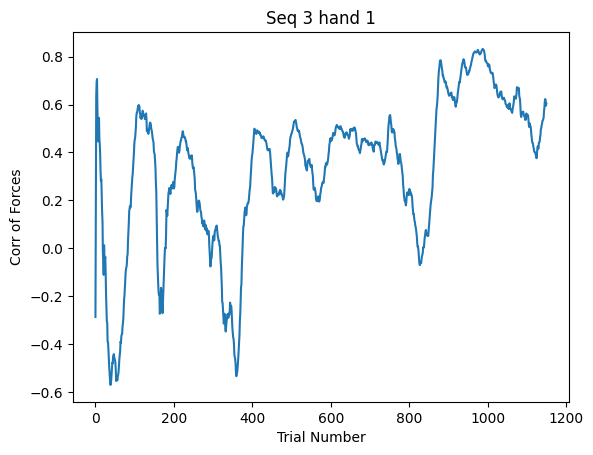

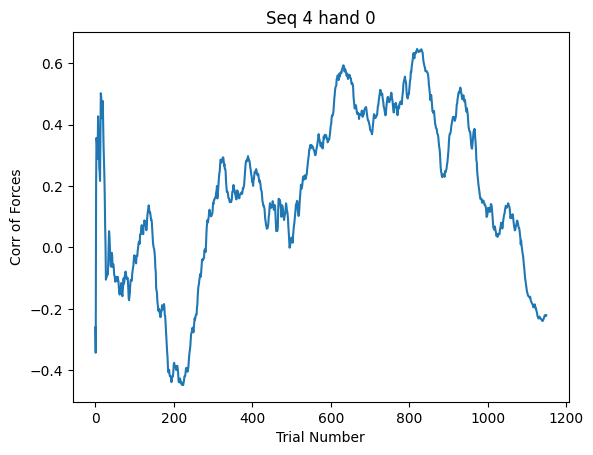

In [226]:
#project and plot random walk on the first 3 principal components interactively in 3D
import plotly.graph_objects as go
num_trials_in_window = 50

for seqnum, seq_data in subjs.groupby('seqType'):
    for hand, hand_data in seq_data.groupby('board'):
        if not (seqnum == 4 and hand == 1):
            forces = []
            for subind, (subnum, subdata) in enumerate(hand_data.groupby('SubNum')):
                error_trials = all_error_trials[seqnum, hand, subnum]
                sub_force = reduced_forces_all_dict[seqnum, hand, subnum].copy()
                sub_force[error_trials-1, :] = np.nan
                for dim in range(n_dim_reduction):
                    sub_force[:,dim] = np.interp(np.arange(0, num_trials), np.arange(0, num_trials)[~np.isnan(sub_force[:,dim])], sub_force[~np.isnan(sub_force[:,dim]),dim])
                forces.append(sub_force)

            forces = np.array(forces)
            starting_forces = forces[:,:num_trials_in_window,:].mean(axis = 1)

            # convolve forces with an averaging window
            kernel = np.ones(num_trials_in_window) / num_trials_in_window
            moving_window_forces = np.zeros((forces.shape[0], forces.shape[1] - num_trials_in_window + 1, forces.shape[2]))
            for i in range(forces.shape[0]):
                for j in range(forces.shape[2]):
                    moving_window_forces[i,:,j] = np.convolve(forces[i,:,j], kernel, mode = 'valid')


            forces_diff_from_start = (moving_window_forces - starting_forces[:,np.newaxis,:])
            corrs = np.corrcoef(forces_diff_from_start[0], forces_diff_from_start[1])
            plt.figure()
            plt.plot([corrs[i, i + num_trials - num_trials_in_window] for i in range(num_trials-num_trials_in_window)])
            plt.title(f'Seq {seqnum} hand {hand}')
            plt.ylabel('Corr of Forces')
            plt.xlabel('Trial Number')




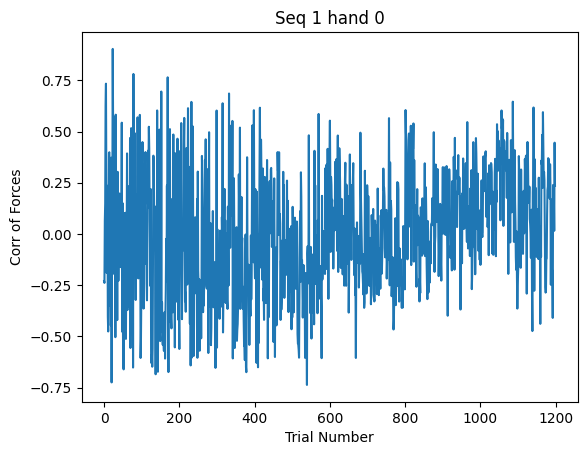

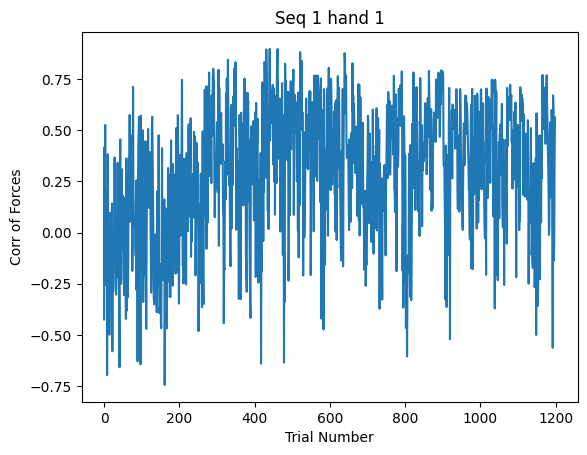

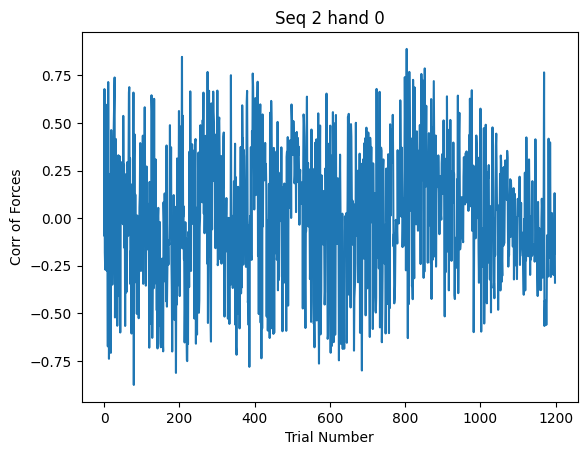

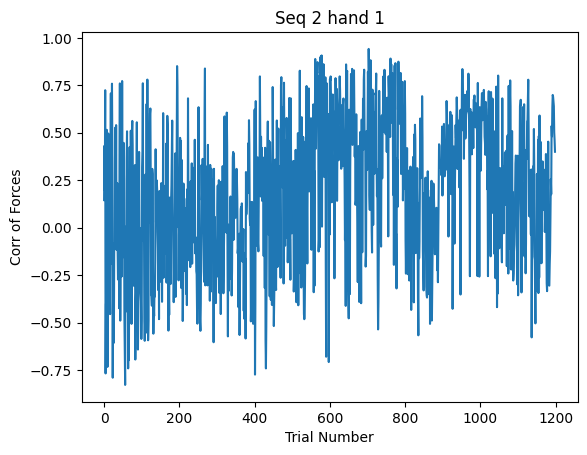

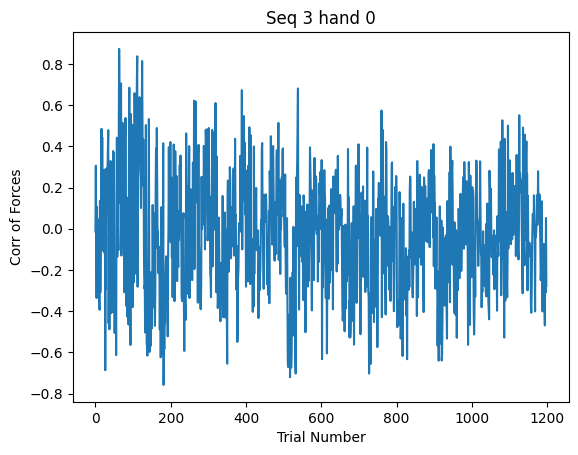

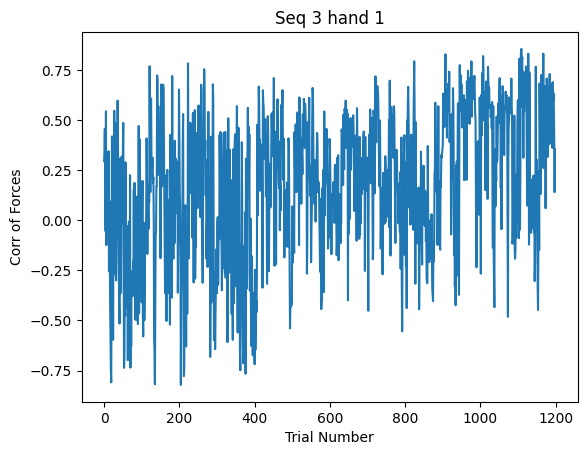

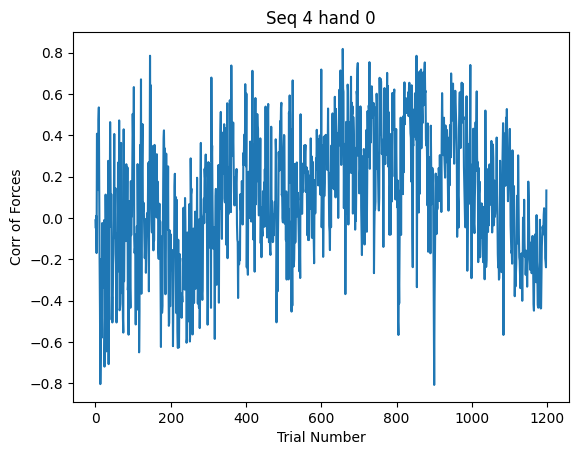

In [214]:
#project and plot random walk on the first 3 principal components interactively in 3D
import plotly.graph_objects as go
num_start_trials = 50

for seqnum, seq_data in subjs.groupby('seqType'):
    for hand, hand_data in seq_data.groupby('board'):
        if not (seqnum == 4 and hand == 1):
            forces = []
            for subind, (subnum, subdata) in enumerate(hand_data.groupby('SubNum')):
                error_trials = all_error_trials[seqnum, hand, subnum]
                sub_force = reduced_forces_all_dict[seqnum, hand, subnum].copy()
                sub_force[error_trials-1, :] = np.nan
                for dim in range(n_dim_reduction):
                    sub_force[:,dim] = np.interp(np.arange(0, num_trials), np.arange(0, num_trials)[~np.isnan(sub_force[:,dim])], sub_force[~np.isnan(sub_force[:,dim]),dim])
                forces.append(sub_force)

            forces = np.array(forces)
            starting_forces = forces[:,:num_start_trials,:].mean(axis = 1)
            forces_diff_from_start = (forces - starting_forces[:,np.newaxis,:])
            corrs = np.corrcoef(forces_diff_from_start[0], forces_diff_from_start[1])
            plt.figure()
            plt.plot([corrs[i, i + num_trials-1] for i in range(num_trials-1)])
            plt.title(f'Seq {seqnum} hand {hand}')
            plt.ylabel('Corr of Forces')
            plt.xlabel('Trial Number')




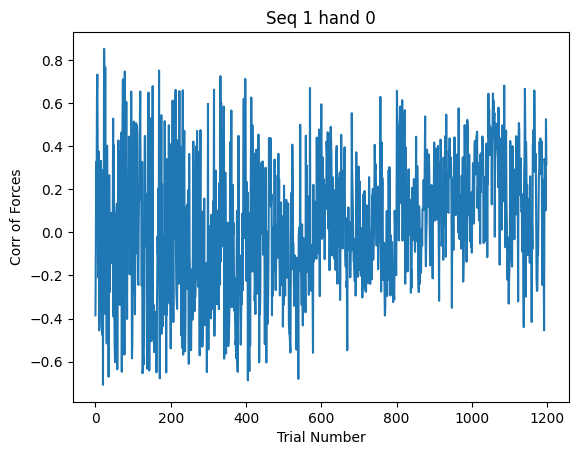

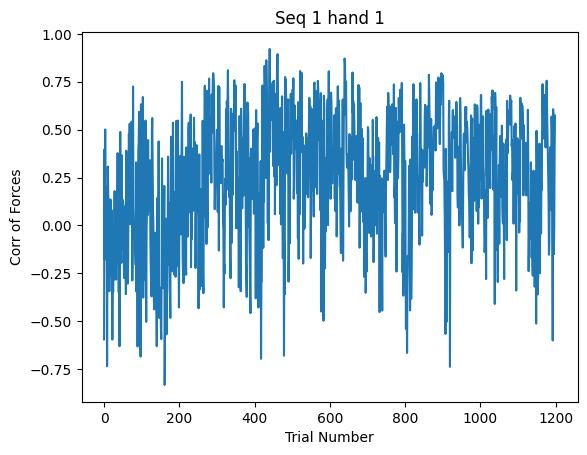

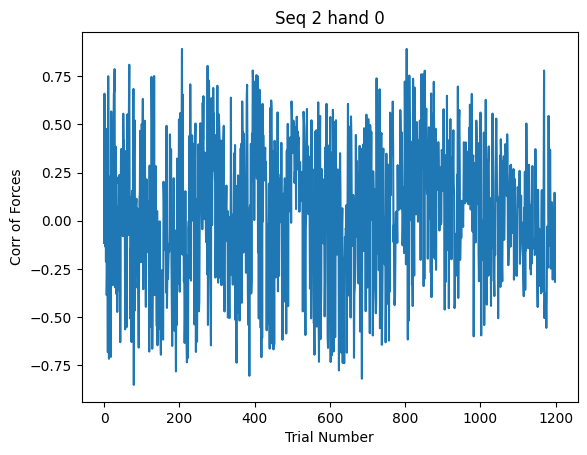

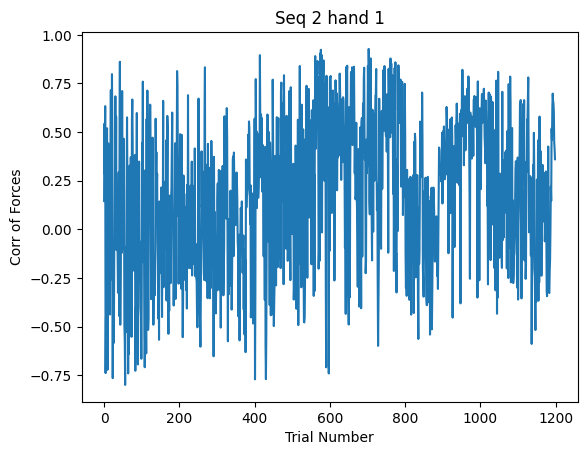

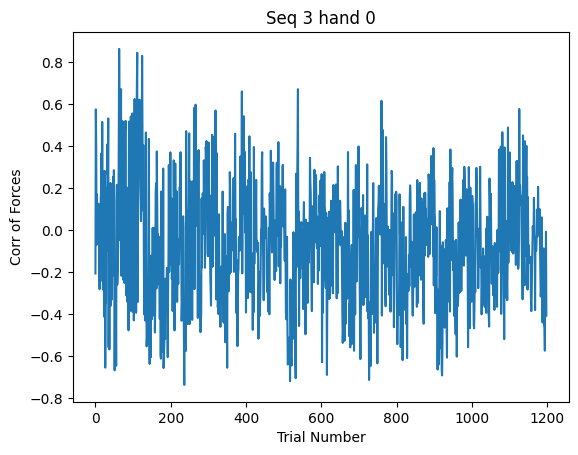

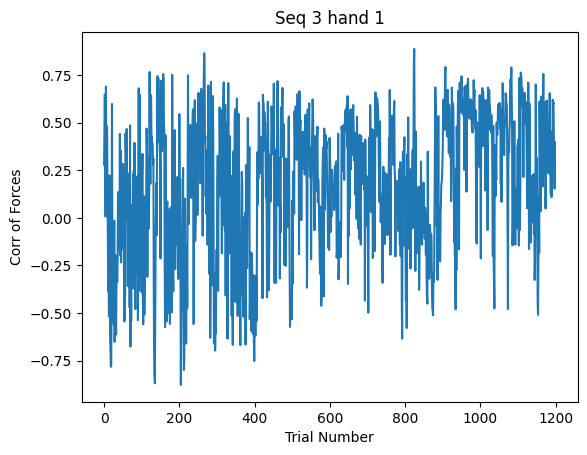

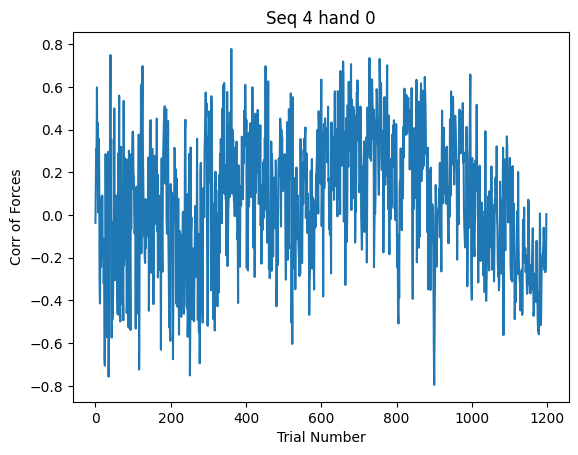

In [201]:
#project and plot random walk on the first 3 principal components interactively in 3D
import plotly.graph_objects as go
num_start_trials = 100

for seqnum, seq_data in subjs.groupby('seqType'):
    for hand, hand_data in seq_data.groupby('board'):
        if not (seqnum == 4 and hand == 1):
            forces = []
            for subind, (subnum, subdata) in enumerate(hand_data.groupby('SubNum')):
                error_trials = all_error_trials[seqnum, hand, subnum]
                sub_force = reduced_forces_all_dict[seqnum, hand, subnum].copy()
                sub_force[error_trials-1, :] = np.nan
                for dim in range(n_dim_reduction):
                    sub_force[:,dim] = np.interp(np.arange(0, num_trials), np.arange(0, num_trials)[~np.isnan(sub_force[:,dim])], sub_force[~np.isnan(sub_force[:,dim]),dim])
                forces.append(sub_force)

            forces = np.array(forces)
            starting_forces = forces[:,:num_start_trials,:].mean(axis = 1)
            forces_diff_from_start = (forces - starting_forces[:,np.newaxis,:])
            corrs = np.corrcoef(forces_diff_from_start[0], forces_diff_from_start[1])
            plt.figure()
            plt.plot([corrs[i, i + num_trials-1] for i in range(num_trials-1)])
            plt.title(f'Seq {seqnum} hand {hand}')
            plt.ylabel('Corr of Forces')
            plt.xlabel('Trial Number')




In [237]:
# #project and plot random walk on the first 3 principal components interactively in 3D
# import plotly.graph_objects as go
# num_start_trials = 100

# for seqnum, seq_data in subjs.groupby('seqType'):
#     for hand, hand_data in seq_data.groupby('board'):
#         if not (seqnum == 4 and hand == 1):
#             forces = []
#             for subind, (subnum, subdata) in enumerate(hand_data.groupby('SubNum')):
#                 error_trials = all_error_trials[seqnum, hand, subnum]
#                 sub_force = reduced_forces_all_dict[seqnum, hand, subnum].copy()
#                 sub_force[error_trials-1, :] = np.nan
#                 for dim in range(n_dim_reduction):
#                     sub_force[:,dim] = np.interp(np.arange(0, num_trials), np.arange(0, num_trials)[~np.isnan(sub_force[:,dim])], sub_force[~np.isnan(sub_force[:,dim]),dim])
#                 forces.append(sub_force)

#             forces = np.array(forces)
#             starting_forces = forces[:,:num_start_trials,:].mean(axis = 1)
#             forces_diff_from_start = (forces - starting_forces[:,np.newaxis,:])
#             corrs = np.corrcoef(forces_diff_from_start[0], forces_diff_from_start[1])
#             plt.figure()
#             # plt.plot([corrs[i, i + num_trials] for i in range(num_trials)])
#             # plot distance from starting point for both subjects on scatter plot determining trial number by color
#             plt.scatter(np.linalg.norm(forces_diff_from_start[0], axis = 1), 
#                         [corrs[i, i + num_trials] for i in range(num_trials)], 
#                         c = np.arange(num_trials), cmap = 'Reds')
#             plt.colorbar()
#             # plt.scatter(np.linalg.norm(forces_diff_from_start[1], axis = 1), 
#             #             [corrs[i, i + num_trials] for i in range(num_trials)], 
#             #             c = np.arange(num_trials), cmap = 'Blues')
#             # plt.colorbar()
#             # plt.plot(np.linalg.norm(forces_diff_from_start[0], axis = 1), label = 'Sub 1')
#             # plt.plot(np.linalg.norm(forces_diff_from_start[1], axis = 1), label = 'Sub 2')
#             plt.title(f'Seq {seqnum} hand {hand}')
#             plt.xlabel('Distance from Start')
#             plt.ylabel('Direction Corr')




In [231]:
#project and plot random walk on the first 3 principal components interactively in 3D
import plotly.graph_objects as go
num_start_trials = 50


all_corrs = []

for seqnum, seq_data in subjs.groupby('seqType'):
    for hand, hand_data in seq_data.groupby('board'):
        if not (seqnum == 4 and hand == 1):
            forces = []
            for subind, (subnum, subdata) in enumerate(hand_data.groupby('SubNum')):
                error_trials = all_error_trials[seqnum, hand, subnum]
                sub_force = reduced_forces_all_dict[seqnum, hand, subnum].copy()
                sub_force[error_trials-1, :] = np.nan
                for dim in range(n_dim_reduction):
                    sub_force[:,dim] = np.interp(np.arange(0, num_trials), np.arange(0, num_trials)[~np.isnan(sub_force[:,dim])], sub_force[~np.isnan(sub_force[:,dim]),dim])
                forces.append(sub_force)

            forces = np.array(forces)
            starting_forces = forces[:,:num_start_trials,:].mean(axis = 1)
            ending_forces = forces[:,-num_start_trials:,:].mean(axis = 1)
            end_start_diff = ending_forces - starting_forces
            corrs = np.corrcoef(end_start_diff[0], end_start_diff[1])
            all_corrs.append(corrs[0,1])
            



            # forces_diff_from_start = (forces - starting_forces[:,np.newaxis,:])
            # corrs = np.corrcoef(forces_diff_from_start[0], forces_diff_from_start[1])
            # plt.figure()
            # plt.plot([corrs[i, i + num_trials-1] for i in range(num_trials-1)])
            # plt.title(f'Seq {seqnum} hand {hand}')
            # plt.ylabel('Corr of Forces')
            # plt.xlabel('Trial Number')




In [236]:
all_corrs

[0.17084128122438744,
 0.6711043641453563,
 -0.2605357180546888,
 0.3342819616308148,
 -0.11571881523768555,
 0.611365550319784,
 -0.22177944905174435]

In [232]:
from scipy.stats import ttest_1samp
ttest_1samp(all_corrs, 0)

TtestResult(statistic=1.1651803279654565, pvalue=0.28816944434638353, df=6)

In [204]:
#project and plot random walk on the first 3 principal components interactively in 3D
import plotly.graph_objects as go
num_start_trials = 100


all_corrs = []

for seqnum, seq_data in subjs.groupby('seqType'):
    for hand, hand_data in seq_data.groupby('board'):
        if not (seqnum == 4 and hand == 1):
            forces = []
            for subind, (subnum, subdata) in enumerate(hand_data.groupby('SubNum')):
                error_trials = all_error_trials[seqnum, hand, subnum]
                sub_force = reduced_forces_all_dict[seqnum, hand, subnum].copy()
                sub_force[error_trials-1, :] = np.nan
                for dim in range(n_dim_reduction):
                    sub_force[:,dim] = np.interp(np.arange(0, num_trials), np.arange(0, num_trials)[~np.isnan(sub_force[:,dim])], sub_force[~np.isnan(sub_force[:,dim]),dim])
                forces.append(sub_force)

            forces = np.array(forces)
            starting_forces = forces[:,:num_start_trials,:].mean(axis = 1)
            ending_forces = forces[:,-num_start_trials:,:].mean(axis = 1)
            end_start_diff = ending_forces - starting_forces
            corrs = np.corrcoef(end_start_diff[0], end_start_diff[1])
            all_corrs.append(corrs[0,1])
            



            # forces_diff_from_start = (forces - starting_forces[:,np.newaxis,:])
            # corrs = np.corrcoef(forces_diff_from_start[0], forces_diff_from_start[1])
            # plt.figure()
            # plt.plot([corrs[i, i + num_trials-1] for i in range(num_trials-1)])
            # plt.title(f'Seq {seqnum} hand {hand}')
            # plt.ylabel('Corr of Forces')
            # plt.xlabel('Trial Number')




<Axes: ylabel='Count'>

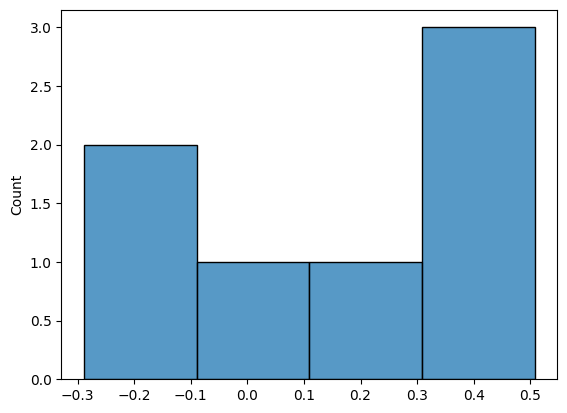

In [229]:
sns.histplot(all_corrs)

In [230]:
from scipy.stats import ttest_1samp
ttest_1samp(all_corrs, 0)

TtestResult(statistic=1.385616305606408, pvalue=0.215171635395478, df=6)